In [1]:
%pip install -r C:\Users\AubreeWang\deep-speaker\requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import sys
import random
import re
import glob
from tqdm import tqdm
import importlib
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import umap

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)
from deep_speaker.test import batch_cosine_similarity
# print(sys.path)
# from sak import speaker_embeddings as se
# from sak import signal_processing as sp
# from sak import vctk


c:\Users\AubreeWang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# the directory wherey you downloaded VCTK. 
vctk_dir = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92"
# the directory where you work i.e. save speaker embeddings.
work_dir = r"C:\Users\AubreeWang\deep-speaker\deep_speaker"

# you should download the deep speaker model
# and describe the path here.
checkpoint_path = r'C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5'

## VCTK embedding space.

In [4]:
def load_vctk_metadata():
    with open(os.path.join(vctk_dir, 'speaker-info.txt')) as f:
        lines = f.read().strip().split('\n')
    
    # remove the header.
    # ID  AGE  GENDER  ACCENTS  REGION COMMENTS
    header = ['id', 'age', 'gender', 'accent', 'region']
    lines = lines[1:]

    ## make a database of metadata.
    meta = pd.DataFrame([], columns=header)
    for i, line in enumerate(lines):
        result = re.findall(r'(\w+)\s+(\d+)\s+(M|F)\s+(\w+)\s*([\w\s]*)', line)
        result = {result[0]}
        meta = pd.concat([meta, pd.DataFrame(result, columns=header)], ignore_index=True)

    return meta

In [5]:
vctk_wavs_dir = os.path.join(vctk_dir, 'wav16')
vctk_embeddings_dir = os.path.join(work_dir, 'embeddings', 'vctk')

# check vctk meta data. 
meta = load_vctk_metadata()
meta

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
...,...,...,...,...,...
105,p363,22,M,Canadian,Toronto
106,p364,23,M,Irish,Donegal
107,p374,28,M,Australian,English
108,p376,22,M,Indian,


In [10]:
## analyse the data
meta_E = meta[meta['accent'] == 'English']
c = Counter(meta_E['gender'])
c.most_common()

[('F', 18), ('M', 15)]

In [11]:
meta_E

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
5,p230,22,F,English,Stockton
6,p231,23,F,English,Southern England
7,p232,23,M,English,Southern England
8,p233,23,F,English,Staffordshire
10,p236,23,F,English,Manchester


In [26]:
meta_T = meta[meta['accent'] == 'American']
c = Counter(meta_T['gender'])
c.most_common()


[('F', 17), ('M', 5)]

In [27]:
meta_T


,id,age,gender,accent,region
64,p294,33,F,American,San Francisco
66,p297,20,F,American,New York
68,p299,25,F,American,California
69,p300,23,F,American,California
70,p301,23,F,American,North Carolina
74,p305,19,F,American,Philadelphia
75,p306,21,F,American,New York
77,p308,18,F,American,Alabama
78,p310,21,F,American,Tennessee
79,p311,21,M,American,Iowa


## extract speaker embeddings.

In [17]:
## test the sample code given by the author.
import random
import os
import sys
import numpy as np

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

# Load the checkpoint. https://drive.google.com/file/d/1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP.
# Also available here: https://share.weiyun.com/V2suEUVh (Chinese users).
model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

# Sample some inputs for WAV/FLAC files for the same speaker.
# To have reproducible results every time you call this function, set the seed every time before calling it.
# np.random.seed(123)
# random.seed(123)
mfcc_001 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic2.wav", SAMPLE_RATE), NUM_FRAMES)
mfcc_002 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic1.wav", SAMPLE_RATE), NUM_FRAMES)

# Call the model to get the embeddings of shape (1, 512) for each file.
predict_001 = model.m.predict(np.expand_dims(mfcc_001, axis=0))
predict_002 = model.m.predict(np.expand_dims(mfcc_002, axis=0))
print(predict_002)

# Do it again with a different speaker.
mfcc_003 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p343\p343_018_mic1.wav", SAMPLE_RATE), NUM_FRAMES)
predict_003 = model.m.predict(np.expand_dims(mfcc_003, axis=0))

# Compute the cosine similarity and check that it is higher for the same speaker.
print('SAME SPEAKER', batch_cosine_similarity(predict_001, predict_002)) # SAME SPEAKER [0.81564593]
print('DIFF SPEAKER', batch_cosine_similarity(predict_001, predict_003)) # DIFF SPEAKER [0.1419204]

1/1 [==============================] - 0s 69ms/step
[[ 1.92996440e-03 -3.43820415e-02 -7.02717155e-02 -1.81998126e-02
  -5.39956354e-02 -4.81954031e-02  1.16921164e-01  7.74025545e-03
  -3.92459966e-02  2.30990187e-03  2.77277064e-02 -2.36859247e-02
   1.57701652e-02 -2.00617835e-02  2.31179595e-02  2.45918408e-02
   3.47300922e-03  2.91852690e-02  7.73091940e-03 -4.17573676e-02
  -6.66369742e-05  4.37875725e-02  2.64287889e-02  5.79762692e-03
  -8.43824539e-03 -5.67319896e-03 -6.39246479e-02  9.16451439e-02
   3.99594055e-03  2.84910528e-03  6.92306459e-02 -7.89325777e-03
  -8.58303383e-02 -1.82017926e-02  5.41119762e-02  1.99111886e-02
  -2.12276820e-02 -2.00185459e-02 -2.38870606e-02 -1.82809052e-03
   2.51415148e-02 -1.32717099e-02 -3.43215056e-02  3.00462898e-02
   3.14591452e-02 -1.04648657e-02 -6.99013658e-03 -9.03603137e-02
   2.24380083e-02  3.38136479e-02 -1.88039541e-02 -5.63938059e-02
  -6.72724098e-02  3.26650380e-03  2.25101132e-02 -1.63931902e-02
   4.22814973e-02  4.930

In [18]:
# create the function of extract_speaker_embedding and calculate the time of extract a single speaker embeddgings
import random
import os
import sys
import numpy as np
import time

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

## make a function which extract speaker embeddings from a wav file.
def extract_speaker_embedding(wav_path):
    mfcc = sample_from_mfcc(read_mfcc(f"{wav_path}", SAMPLE_RATE), NUM_FRAMES)
    speaker_embedding = model.m.predict(np.expand_dims(mfcc, axis=0))
    return speaker_embedding

time_start = time.time()
speaker_embeddings =extract_speaker_embedding(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p225\p225_002_mic1.wav")
elapsed_time = time.time() - time_start
print(f"elapsed time is {elapsed_time}[s]")

1/1 [==============================] - 1s 638ms/step
elapsed time is 0.796271562576294[s]


In [11]:
# # randomly pick 100 wavs from each speaker 
# # save the file_paths in a list

# #make a list of the 33 folder_paths
# speaker_ids = meta_["id"].tolist()
# parent_folder_path = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed" 
# num_files_to_pick = 100
# file_paths = []
# folder_paths = []
# for folder_name in os.listdir(parent_folder_path):
#     if folder_name in speaker_ids:
#         folder_path = os.path.join(parent_folder_path, folder_name)
#         folder_paths.append(folder_path)
#         file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".wav")]
#         # Randomly pick 100 files from the folder
#         random_files = random.sample(file_list, num_files_to_pick)
#         #create a list of 3300 file_paths        
#         for file_name in random_files:
#             file_path = os.path.join(folder_path, file_name)
#             file_paths.append(file_path)
            
# import json
# # Saving the list to a file using json
# with open('file_paths of 3300 speaker_embeddings.json', 'w') as file:
#     json.dump(file_paths, file)


In [20]:
# randomly pick 100 wavs from each American speaker
# save the file_paths in a list

#make a list of the 33 folder_paths
speaker_ids = meta_T["id"].tolist()
parent_folder_path = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed" 
num_files_to_pick = 100
file_paths = []
folder_paths = []
for folder_name in os.listdir(parent_folder_path):
    if folder_name in speaker_ids:
        folder_path = os.path.join(parent_folder_path, folder_name)
        folder_paths.append(folder_path)
        file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".wav")]
        # Randomly pick 100 files from the folder
        random_files = random.sample(file_list, num_files_to_pick)
        #create a list of 3300 file_paths        
        for file_name in random_files:
            file_path = os.path.join(folder_path, file_name)
            file_paths.append(file_path)
            
import json
# Saving the list to a file using json
with open('file_paths of American speaker_embeddings.json', 'w') as file:
    json.dump(file_paths, file)

In [12]:
# # Loading the list from the file
# with open('file_paths of 3300 speaker_embeddings.json', 'r') as file:
#     loaded_list = json.load(file)

# print(loaded_list)  

['C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_024_mic1.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_356_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_244_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_144_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_019_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_002_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_118_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p225\\p225_303_mic1.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0

In [28]:
# Loading the list from the file
with open('file_paths of American speaker_embeddings.json', 'r') as file:
    loaded_list = json.load(file)

print(loaded_list) 

['C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_045_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_307_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_194_mic1.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_036_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_004_mic1.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_162_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_376_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\wav48_silence_trimmed\\p294\\p294_230_mic2.wav', 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0

In [13]:
# #extract the embeddings of the list and save them in a folder

# # Create a folder to store the .npy files
# output_folder = "3300 speaker_embeddings"
# os.makedirs(output_folder, exist_ok=True)
# arr_names=[]
# for file in loaded_list:
#     arr_name=f'{str(file)[88:101]}'
#     arr_path = os.path.join(output_folder, arr_name)
#     speaker_embeddings=extract_speaker_embedding(file)
#     np.save(arr_path,speaker_embeddings )


1/1 [==============================] - 0s 468ms/step


In [ ]:
#extract the embeddings of the list and save them in a folder

# Create a folder to store the .npy files
output_folder = "American speaker_embeddings"
os.makedirs(output_folder, exist_ok=True)
arr_names=[]
for file in loaded_list:
    arr_name=f'{str(file)[88:101]}'
    arr_path = os.path.join(output_folder, arr_name)
    speaker_embeddings=extract_speaker_embedding(file)
    np.save(arr_path,speaker_embeddings )


In [30]:
#rename the .npy and add gender information
import pandas as pd

# Assuming you have a DataFrame named 'df' with 'id' and 'gender' columns
meta_T
# Directory path where the files are located
directory = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\American speaker_embeddings"

# Iterate over the DataFrame rows
for index, row in meta_T.iterrows():
    file_id = row['id']
    gender = row['gender']
    
    # Generate the old and new file names
    for filename in os.listdir(directory):
        if file_id in filename:
            old_file_path = os.path.join(directory, filename)
            file_name, file_extension = os.path.splitext(filename)
            new_file_name = f"{file_name}_{gender}{file_extension}"
            new_file_path = os.path.join(directory, new_file_name)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)

## visualize.

C:\Users\YiqiuWang\AppData\Local\Temp\ipykernel_38688\2270819268.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")


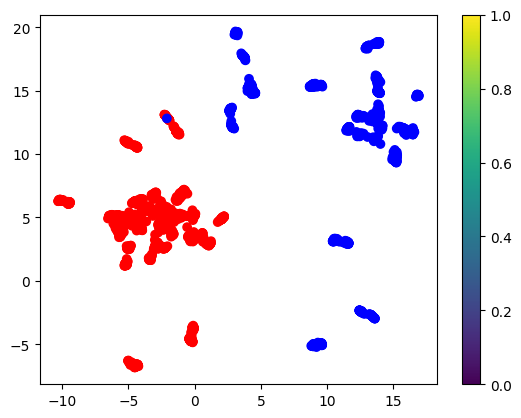

<Figure size 640x480 with 0 Axes>

In [16]:
# #use UMAP to plot them
# folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 speaker_embeddings"

# #Create empty lists to store the data and gender labels
# data = []
# gender_labels = []

# for file_name in os.listdir(folder_path):
#     if file_name.endswith(".npy"):
#         file_path = os.path.join(folder_path, file_name)
#         file_data = np.load(file_path)
        
#         # Extract gender from the filename
#         gender = file_name.split("_")[-1][0]
        
#         data.append(file_data)
#         gender_labels.append(gender)

# colors = {'F': 'red', 'M': 'blue'}
# mapped_colors = [colors[label] for label in gender_labels]
# #Concatenate the data and convert the labels to an array
# npdata = np.concatenate(data, axis=0)

# #Perform UMAP dimensionality reduction
# reducer = umap.UMAP(n_components=2, random_state=42)
# embedding = reducer.fit_transform(npdata)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")
# plt.colorbar()
# plt.show()
# plt.savefig("output.png")

C:\Users\YiqiuWang\AppData\Local\Temp\ipykernel_109116\3157876852.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")


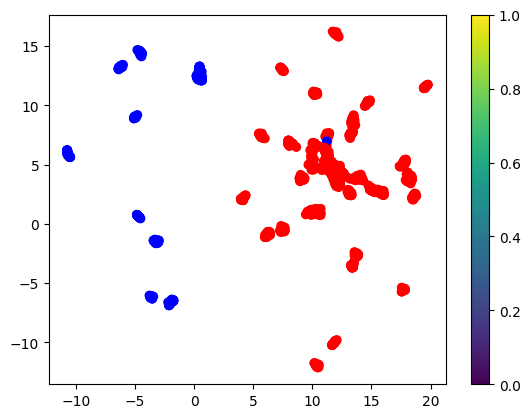

<Figure size 640x480 with 0 Axes>

In [35]:
#use UMAP to plot them
folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\American speaker_embeddings"

#Create empty lists to store the data and gender labels
data = []
gender_labels = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".npy"):
        file_path = os.path.join(folder_path, file_name)
        file_data = np.load(file_path)
        
        # Extract gender from the filename
        gender = file_name.split("_")[-1][0]
        
        data.append(file_data)
        gender_labels.append(gender)

colors = {'F': 'red', 'M': 'blue'}
mapped_colors = [colors[label] for label in gender_labels]
#Concatenate the data and convert the labels to an array
npdata = np.concatenate(data, axis=0)

#Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(npdata)

plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")
plt.colorbar()
plt.show()
plt.savefig("American_accent.png")

In [23]:
# folder_path =r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 speaker_embeddings" 

# gender_info = []  # List to store gender information (0 for male, 1 for female)

# for file_name in os.listdir(folder_path):
#     if file_name.endswith(".npy"):
#         gender = file_name[-5]  # Extract the last letter of the file name
#         if gender == "M":
#             gender_info.append(0)  # Male
#         elif gender == "F":
#             gender_info.append(1)  # Female
#         else:
#             gender_info.append(None)  # Handle other cases if necessary
        
# print(gender_info)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [36]:
folder_path =r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\American speaker_embeddings" 

gender_info = []  # List to store gender information (0 for male, 1 for female)

for file_name in os.listdir(folder_path):
    if file_name.endswith(".npy"):
        gender = file_name[-5]  # Extract the last letter of the file name
        if gender == "M":
            gender_info.append(0)  # Male
        elif gender == "F":
            gender_info.append(1)  # Female
        else:
            gender_info.append(None)  # Handle other cases if necessary
        
print(gender_info)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [19]:
# # calculate the distances between the embeddings and the hyperplane, input is the list of embeddings
# from sklearn import svm
# clf = svm.SVC(kernel='linear')
# clf.fit(npdata, gender_info)

# coefficients = clf.coef_[0]
# intercept = clf.intercept_[0]

# norm = np.linalg.norm(coefficients)
# normalized_coefficients = coefficients / norm

# distances = np.abs(np.dot(data, normalized_coefficients) + intercept)

# np.save('distances.npy', distances)


[[0.14825992]
 [0.06405857]
 [0.08769687]
 ...
 [0.240851  ]
 [0.26191841]
 [0.22599242]]


In [46]:
# function of feminine_level 

from sklearn.model_selection import train_test_split
from sklearn import svm

# Split the data
male_data = npdata[gender_info == 0]
female_data = npdata[gender_info == 1]

# Train an SVM model
X_train, X_test, y_train, y_test = train_test_split(npdata, gender_info, test_size=0.2, random_state=42)
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Get the hyperplane
hyperplane_weights = svm_model.coef_[0]
hyperplane_bias = svm_model.intercept_[0]

def feminine_level(wav_path):
    embedding=extract_speaker_embedding(wav_path)
    d = (np.dot(embedding, hyperplane_weights) + hyperplane_bias) / np.linalg.norm(hyperplane_weights)
    return d

# test=feminine_level(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p226\p226_107_mic2.wav")
# test

In [31]:
# # save the feminine level of the 3300 wavs
# output_folder = "3300 feminine _level"
# os.makedirs(output_folder, exist_ok=True)
# arr_names=[]
# for file in loaded_list:
#     arr_name=f'{str(file)[88:101]}'
#     arr_path = os.path.join(output_folder, arr_name)
#     fl=feminine_level(file)
#     np.save(arr_path,fl)
    
 

1/1 [==============================] - 2s 2s/step


In [49]:
# # create a list to save the feminine level
# folder_path=r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 feminine _level"
# fl_list=[]
# for file_name in os.listdir(folder_path):
#     file_path=os.path.join(folder_path, file_name)
#     loaded_data = np.load(file_path)
#     fl = float(loaded_data[0])
#     fl_list.append(fl)


In [54]:
# # calculate the average feminine level of each speaker
# # add feminine_level column to meta_
# def calculate_averages(numbers_list, window_size):
#     num_windows = len(numbers_list) // window_size
#     averages = []
#     for i in range(num_windows):
#         start_index = i * window_size
#         end_index = (i + 1) * window_size
#         window = numbers_list[start_index:end_index]
#         average = sum(window) / len(window)
#         averages.append(average)
#     return averages

# average_feminine_level=calculate_averages(fl_list, 100)
# meta_["feminine_level"] = average_feminine_level
# meta_.to_csv(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\meta_.csv", index=False) 

      id age gender   accent             region  feminine_level
0   p225  23      F  English  Southern  England        0.192557
1   p226  22      M  English             Surrey       -0.267441
2   p227  38      M  English            Cumbria       -0.318194
3   p228  22      F  English  Southern  England        0.265209
4   p229  23      F  English  Southern  England        0.217628
5   p230  22      F  English           Stockton        0.242983
6   p231  23      F  English  Southern  England        0.215748
7   p232  23      M  English  Southern  England       -0.262936
8   p233  23      F  English      Staffordshire        0.323843
10  p236  23      F  English         Manchester        0.258116
13  p239  22      F  English        SW  England        0.276351
14  p240  21      F  English  Southern  England        0.272036
16  p243  22      M  English             London       -0.291486
17  p244  22      F  English         Manchester        0.274555
23  p250  22      F  English        SE  

C:\Users\YiqiuWang\AppData\Local\Temp\ipykernel_38688\649946203.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_["feminine_level"] = average_feminine_level


In [55]:
# to get the list of speakers:
# vctk_dir = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92"
# speakers.sort()

# to get text path from the wav path
# wav_dir = os.path.join(vctk_dir, 'wav16')
# txt_dir = os.path.join(vctk_dir, 'txt')
# speaker = 'p225'
# wav_path = os.path.join(wav_dir, speaker, 'p225_287.wav')
# txt_path = wav_path.replace(wav_dir, txt_dir).replace('.wav', '.txt')

In [44]:
#make a list of the 33 folder_paths
speaker_ids = meta_E["id"].tolist()
parent_folder_path = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt"
file_paths = []
folder_paths_list = []
for folder_name in os.listdir(parent_folder_path):
    if folder_name in speaker_ids:
        folder_path = os.path.join(parent_folder_path, folder_name)
        folder_paths_list.append(folder_path)
        file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".txt")]
 

folder_paths_list

['C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p225',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p226',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p227',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p228',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p229',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p230',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p231',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p232',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p233',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p236',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p239',
 'C:\\Users\\AubreeWang\\Downloads\\DS_10283_3443\\VCTK-Corpus-0.92\\txt\\p240',
 'C:\\Users\\AubreeWang\\Dow

In [45]:
# find the same contents produced by 33 speakers
# result: there are 8 same sentences

import os

def remove_spaces(text):
    return ' '.join(text.split())

def find_duplicate_files(folder_paths):
    # Dictionary to store the content of each file
    file_content_dict = {}

    for folder_path in folder_paths:
        # Walk through the folder and its subdirectories
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                # Check if the file is a text file
                if filename.endswith('.txt'):
                    filepath = os.path.join(foldername, filename)
                    with open(filepath, 'r') as file:
                        file_content = file.read()
                        file_content_stripped = remove_spaces(file_content)

                    # Add the stripped file content to the dictionary and store its path
                    if file_content_stripped in file_content_dict:
                        file_content_dict[file_content_stripped].append(filepath)
                    else:
                        file_content_dict[file_content_stripped] = [filepath]

    # Filter out files with unique content, only keep duplicates with 33 occurrences
    duplicate_files = {content: paths for content, paths in file_content_dict.items() if len(paths) == 33}

    return duplicate_files

if __name__ == "__main__":
    # Replace 'folder_paths_list' with your list of folder paths containing the files.
    duplicate_files = find_duplicate_files(folder_paths_list)

    if duplicate_files:
        print("Duplicate files found with 33 occurrences:")
        for idx, (content, paths) in enumerate(duplicate_files.items(), 1):
            print(f"Content: {content}")
            print("Files:")
            for path in paths:
                print(f"- {path}")
            print()

            # Save the list of file paths for each content with 33 occurrences to a separate text file.
            with open(f"duplicate_files_list_{idx}.txt", 'w') as file:
                for path in paths:
                    file.write(path + "\n")
    else:
        print("No duplicate files found with 33 occurrences.")



Duplicate files found with 33 occurrences:
Content: Ask her to bring these things with her from the store.
Files:
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p225\p225_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p226\p226_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p227\p227_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p228\p228_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p229\p229_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p230\p230_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p231\p231_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p232\p232_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p233\p233_002.txt
- C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\txt\p236\p236_002.txt
- C:\Users\AubreeWang\Downloads\DS_1

In [47]:
# get the wav paths

def get_wav_path(txt_path):  
# Replace 'txt' with 'wav48_silence_trimmed'
    wav_path = txt_path.replace('\\txt\\', '\\wav48_silence_trimmed\\')
    
    # Replace '_mic1.txt' with '_mic1.wav'
    wav_path = wav_path.replace('.txt', '_mic1.wav')
    return wav_path

def update_txt_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            txt_file_path = os.path.join(folder_path, filename)
            print(f"Processing {txt_file_path}")

            with open(txt_file_path, "r") as input_file:
                txt_file_paths = input_file.read().splitlines()

            # Get corresponding wav file paths
            wav_path = [get_wav_path(txt_path) for txt_path in txt_file_paths]

            # Update the original file directly
            with open(txt_file_path, "w") as output_file:
                output_file.write("\n".join(wav_path))

            print(f"Updated {filename}")

# Replace "folder_path" with the path to the folder containing your .txt files
folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook"
update_txt_files_in_folder(folder_path)

Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_1.txt
Updated duplicate_files_list_1.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_2.txt
Updated duplicate_files_list_2.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_3.txt
Updated duplicate_files_list_3.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_4.txt
Updated duplicate_files_list_4.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_5.txt
Updated duplicate_files_list_5.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_6.txt
Updated duplicate_files_list_6.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_7.txt
Updated duplicate_files_list_7.txt
Processing C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\duplicate_files_list_8.txt
Updated dup

In [48]:
import os

input_folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook"
output_file_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\combined_paths"

combined_content = ""

# Combine the contents of all .txt files into a single string
for filename in os.listdir(input_folder_path):
    if filename.endswith(".txt"):
        txt_file_path = os.path.join(input_folder_path, filename)
        with open(txt_file_path, "r") as txt_file:
            content = txt_file.read().strip()
            combined_content += content + "\n"

        # Delete the original .txt file
        os.remove(txt_file_path)

# Write the combined contents to the output .txt file
with open(output_file_path, "w") as output_file:
    output_file.write(combined_content)




In [49]:

file_paths_ = []
with open(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\combined_paths", "r") as file:
    file_paths_ = [line.rstrip() for line in file]



In [50]:
def group_paths_by_pxxx(file_paths):
    grouped_paths = {}
    for path in file_paths:
        pxxx_value = path.split("\\")[-2]
        if pxxx_value not in grouped_paths:
            grouped_paths[pxxx_value] = []
        grouped_paths[pxxx_value].append(path)

    return [path for group in grouped_paths.values() for path in group]


grouped_file_paths = group_paths_by_pxxx(file_paths_)




In [51]:
#extract the embeddings of the list and save them in a folder

# Create a folder to store the .npy files

output_folder = "speaker_embeddings_"
os.makedirs(output_folder, exist_ok=True)
arr_names=[]
for file in grouped_file_paths:
    arr_name=f'{str(file)[88:101]}'
    arr_path = os.path.join(output_folder, arr_name)
    speaker_embeddings=extract_speaker_embedding(file)
    np.save(arr_path,speaker_embeddings )


1/1 [==============================] - 0s 152ms/step


In [52]:
#rename the .npy and add gender information
import pandas as pd

# Assuming you have a DataFrame named 'df' with 'id' and 'gender' columns
meta_E
# Directory path where the files are located
directory = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\speaker_embeddings_"

# Iterate over the DataFrame rows
for index, row in meta_E.iterrows():
    file_id = row['id']
    gender = row['gender']
    
    # Generate the old and new file names
    for filename in os.listdir(directory):
        if file_id in filename:
            old_file_path = os.path.join(directory, filename)
            file_name, file_extension = os.path.splitext(filename)
            new_file_name = f"{file_name}_{gender}{file_extension}"
            new_file_path = os.path.join(directory, new_file_name)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)

C:\Users\YiqiuWang\AppData\Local\Temp\ipykernel_109116\2891472482.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")


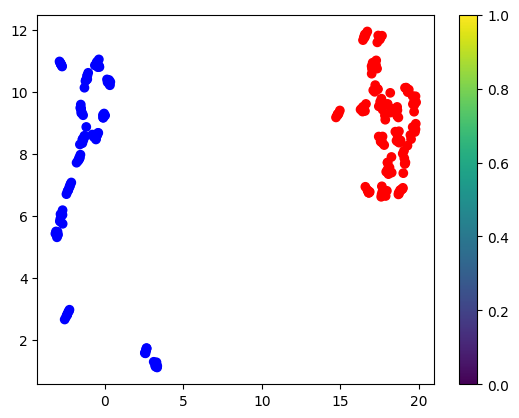

<Figure size 640x480 with 0 Axes>

In [53]:
#use UMAP to plot them
folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\speaker_embeddings_"

#Create empty lists to store the data and gender labels
data = []
gender_labels = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".npy"):
        file_path = os.path.join(folder_path, file_name)
        file_data = np.load(file_path)
        
        # Extract gender from the filename
        gender = file_name.split("_")[-1][0]
        
        data.append(file_data)
        gender_labels.append(gender)

colors = {'F': 'red', 'M': 'blue'}
mapped_colors = [colors[label] for label in gender_labels]
#Concatenate the data and convert the labels to an array
npdata = np.concatenate(data, axis=0)

#Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(npdata)

plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")
plt.colorbar()
plt.show()
plt.savefig("plot_E.png")

In [54]:
folder_path =r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\speaker_embeddings_" 

gender_info = []  # List to store gender information (0 for male, 1 for female)

for file_name in os.listdir(folder_path):
    if file_name.endswith(".npy"):
        gender = file_name[-5]  # Extract the last letter of the file name
        if gender == "M":
            gender_info.append(0)  # Male
        elif gender == "F":
            gender_info.append(1)  # Female
        else:
            gender_info.append(None)  # Handle other cases if necessary
        
print(gender_info)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [186]:
# # function of feminine_level 

# from sklearn.model_selection import train_test_split
# from sklearn import svm

# # Split the data
# male_data = npdata[gender_info == 0]
# female_data = npdata[gender_info == 1]

# # Train an SVM model
# X_train, X_test, y_train, y_test = train_test_split(npdata, gender_info, test_size=0.2, random_state=42)
# svm_model = svm.SVC(kernel='linear')
# svm_model.fit(X_train, y_train)

# # Get the hyperplane
# hyperplane_weights = svm_model.coef_[0]
# hyperplane_bias = svm_model.intercept_[0]

# def feminine_level(wav_path):
#     embedding=extract_speaker_embedding(wav_path)
#     d = (np.dot(embedding, hyperplane_weights) + hyperplane_bias) / np.linalg.norm(hyperplane_weights)
#     return d


In [55]:
# save the feminine level of the 264 wavs
output_folder = "feminine _level_"
os.makedirs(output_folder, exist_ok=True)
arr_names=[]
for file in grouped_file_paths:
    arr_name=f'{str(file)[88:101]}'
    arr_path = os.path.join(output_folder, arr_name)
    fl=feminine_level(file)
    np.save(arr_path,fl)
    

1/1 [==============================] - 0s 194ms/step


In [56]:
# create a list to save the feminine level
folder_path=r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\feminine _level_"
fl_list=[]
for file_name in os.listdir(folder_path):
    file_path=os.path.join(folder_path, file_name)
    loaded_data = np.load(file_path)
    fl = float(loaded_data[0])
    fl_list.append(fl)


In [57]:
# calculate the average feminine level of each speaker
# add feminine_level column to meta_
def calculate_averages(numbers_list, window_size):
    num_windows = len(numbers_list) // window_size
    averages = []
    for i in range(num_windows):
        start_index = i * window_size
        end_index = (i + 1) * window_size
        window = numbers_list[start_index:end_index]
        average = sum(window) / len(window)
        averages.append(average)
    return averages

average_feminine_level=calculate_averages(fl_list, 8)
meta_E["feminine_level"] = average_feminine_level
meta_E.to_csv(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\meta_.csv", index=False) 
meta_E

C:\Users\YiqiuWang\AppData\Local\Temp\ipykernel_109116\160549078.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_E["feminine_level"] = average_feminine_level


,id,age,gender,accent,region,feminine_level
0,p225,23,F,English,Southern England,0.072542
1,p226,22,M,English,Surrey,-0.111766
2,p227,38,M,English,Cumbria,-0.206579
3,p228,22,F,English,Southern England,0.237809
4,p229,23,F,English,Southern England,0.331993
5,p230,22,F,English,Stockton,0.227650
6,p231,23,F,English,Southern England,0.263052
7,p232,23,M,English,Southern England,-0.219432
8,p233,23,F,English,Staffordshire,0.350875
10,p236,23,F,English,Manchester,0.280202
